# PolEval Automatic Cyberbullying Detection
### Piotr Kaczmarek s30216

https://2019.poleval.pl/index.php/tasks/task6

Task 6-1: Harmful vs non-harmful

In this task, the participants are to distinguish between normal/non-harmful tweets (class: 0) and tweets that contain any kind of harmful information (class: 1). This includes cyberbullying, hate speech and related phenomena. The data for the task is available now and can be downloaded from the link provided below.

In [1]:
import pandas as pd
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

## 1. Wczytanie i analiza datasetu

In [2]:
train_tags_path = '/content/drive/MyDrive/INL/projekt/train/training_set_clean_only_tags.txt'
train_text_path = '/content/drive/MyDrive/INL/projekt/train/training_set_clean_only_text.txt'
test_tags_path = '/content/drive/MyDrive/INL/projekt/test/test_set_clean_only_tags.txt'
test_text_path = '/content/drive/MyDrive/INL/projekt/test/test_set_clean_only_text.txt'

df_train_tags = pd.read_csv(train_tags_path, sep='\t', header=None)
df_train_text = pd.read_csv(train_text_path, sep='\t', header=None)
df_test_tags = pd.read_csv(test_tags_path, sep='\t', header=None)
df_test_text = pd.read_csv(test_text_path, sep='\t', header=None)

df_train_combined = pd.concat([df_train_tags, df_train_text], axis=1)
df_train_combined.columns = ['isHarmful', 'text']
df_test_combined = pd.concat([df_test_tags, df_test_text], axis=1)
df_test_combined.columns = ['isHarmful', 'text']

df_train_combined.head(6)

,isHarmful,text
0,0,Dla mnie faworytem do tytułu będzie Cracovia. ...
1,0,@anonymized_account @anonymized_account Brawo ...
2,0,"@anonymized_account @anonymized_account Super,..."
3,0,@anonymized_account @anonymized_account Musi. ...
4,0,"Odrzut natychmiastowy, kwaśna mina, mam problem"
5,0,"Jaki on był fajny xdd pamiętam, że spóźniłam s..."


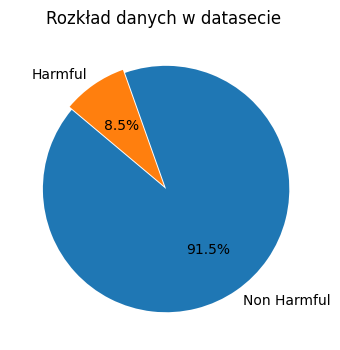

W datasecie znajduje się 9190 wpisów otagowanych jako Non Hamrful oraz 851 oznaczonych jako Harmful
Stosunek liczby wpisów Non Harmful do liczby wpisów Harmful wynosi 10.8


In [3]:
df_train_tags.value_counts()
no_harmful_cnt = df_train_tags.value_counts()[0]
harmful_cnt = df_train_tags.value_counts()[1]
labels = ["Non Harmful","Harmful"]

plt.figure(figsize=(8,4))
plt.pie([no_harmful_cnt, harmful_cnt], labels=labels, autopct='%1.1f%%',
        startangle=140, explode=(0.03, 0))
plt.title("Rozkład danych w datasecie")
plt.show()

print(f"W datasecie znajduje się {no_harmful_cnt} wpisów otagowanych jako Non Hamrful oraz {harmful_cnt} oznaczonych jako Harmful")
print(f"Stosunek liczby wpisów Non Harmful do liczby wpisów Harmful wynosi {round(no_harmful_cnt/harmful_cnt, 2)}")

In [4]:
df_train_combined['text_len'] = df_train_combined['text'].apply(lambda x: len(x))
longest_sentence = df_train_combined.loc[df_train_combined['text_len'].idxmax()]
shortest_sentence = df_train_combined.loc[df_train_combined['text_len'].idxmin()]

print(f"Najdłuższy wpis w datasecie ma długość {longest_sentence['text_len']} znaków")
print(f"Najdłuższyh wpis to: {longest_sentence['text']}")
print(f"Najkrótszy wpis w datasecie ma długość {shortest_sentence['text_len']} znaków")
print(f"Nakrótszy wpis to {shortest_sentence['text']}")

Najdłuższy wpis w datasecie ma długość 214 znaków
Najdłuższyh wpis to: @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account Dla nich każda prawda to chamstwo.
Najkrótszy wpis w datasecie ma długość 6 znaków
Nakrótszy wpis to #NAME?


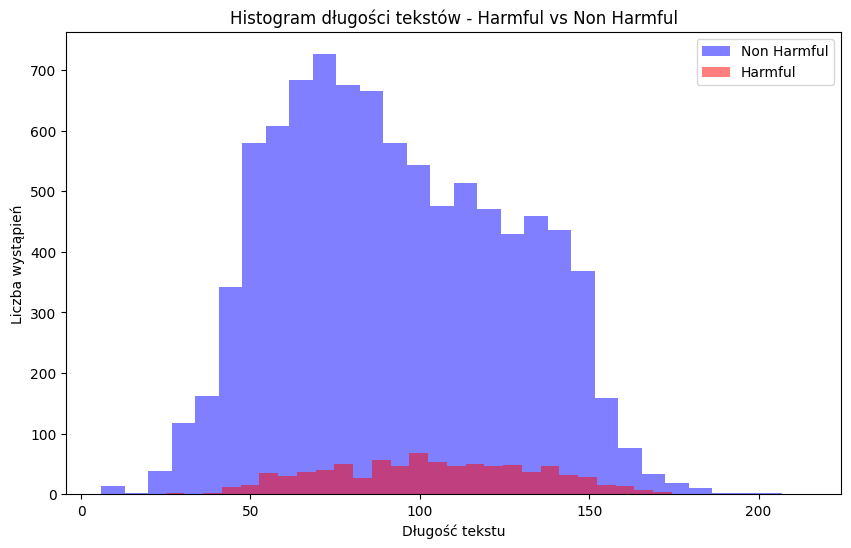

In [5]:
df_harm_lens = df_train_combined[df_train_combined['isHarmful'] == 1]['text_len']
df_noharm_lens = df_train_combined[df_train_combined['isHarmful'] == 0]['text_len']

plt.figure(figsize=(10,6))
plt.hist(df_noharm_lens, bins=30, alpha=0.5, label='Non Harmful', color='blue')
plt.hist(df_harm_lens, bins=30, alpha=0.5, label='Harmful', color='red')

plt.legend()
plt.title('Histogram długości tekstów - Harmful vs Non Harmful')
plt.xlabel('Długość tekstu')
plt.ylabel('Liczba wystąpień')
plt.show()

Na tym wykresie bardziej istotny jest sam kształt histogramów, niż porównanie ich rozmiarów. Tweetów oznaczonych jako "Non-harmful" jest znacznie więcej stąd dysproporcja. Widać jednak że wśród tweetów "Non-harmful" więcej jest wpisów o krótszej długości.

# Preprocessing

In [6]:
def preprocess_text(text):
    text = text.lower()  # Usuwanie wielkich liter
    text = re.sub(r'@\S+', '', text)  # Usuwanie '@'... (często występują ze względu na zastąpienie nazw użytowników przez @anonymized_account)
    text = re.sub(r'http\S+|www\S+', '', text)  # Usuwanie linków
    text = re.sub(r'\n+', ' ', text)  # Usuwanie nowych linii
    text = re.sub(r'\\n', ' ', text)  # Usuwanie \n - znaków nowej linii
    text = re.sub(r'\s+', ' ', text).strip()  # Usuwanie zbędnych spacji

    # Usuwanie polskich stop-words
    pl_stopwords = open('/content/drive/MyDrive/INL/projekt/polish_stopwords.txt', 'r', encoding='utf-8').read().split('\n')
    pl_stopwords = [word for word in pl_stopwords if word != '']
    text = ' '.join([word for word in text.split() if word.lower() not in pl_stopwords])

    # Usuwanie znaków specjalnych
    text = re.sub(r'[^a-zA-Z0-9ąćęłńóśźżĄĆĘŁŃÓŚŹŻ\s]', '', text)

    return text

In [7]:
print(f"Przed transforamcją:")
print(df_train_combined['text'].head(5))
df_train_combined['text'] = df_train_combined['text'].apply(preprocess_text)
df_test_combined['text'] = df_test_combined['text'].apply(preprocess_text)
print(f"Po transforamcji:")
print(df_train_combined['text'].head(5))

Przed transforamcją:
0    Dla mnie faworytem do tytułu będzie Cracovia. ...
1    @anonymized_account @anonymized_account Brawo ...
2    @anonymized_account @anonymized_account Super,...
3    @anonymized_account @anonymized_account Musi. ...
4      Odrzut natychmiastowy, kwaśna mina, mam problem
Name: text, dtype: object
Po transforamcji:
0     faworytem tytułu cracovia zobaczymy typ sprawdzi
1                          brawo daria kibic dobre złe
2    super polski premier składa kwiaty grobach kol...
3                                musi innej drogi mamy
4            odrzut natychmiastowy kwaśna mina problem
Name: text, dtype: object


### Polish stop-words
Plik pozyskany z https://github.com/bieli/stopwords/blob/master/polish.stopwords.txt.

In [8]:
pl_stopwords_path = r'/content/drive/MyDrive/INL/projekt/polish_stopwords.txt'
pl_stopwords = open(pl_stopwords_path, 'r', encoding='utf-8').read().split('\n')
pl_stopwords = [word for word in pl_stopwords if word != '']
print(f"Liczba słów z listy stop-words: {len(pl_stopwords)}")
print(f'Przykładowe słowa z listy stop-words: {pl_stopwords[:10]}')

Liczba słów z listy stop-words: 350
Przykładowe słowa z listy stop-words: ['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']


### Lematyzacja
Sprowadzanie wyrazów do podstawowej formy

In [9]:
!python -m spacy download pl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 66.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
nlp = spacy.load("pl_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

print("Przed lematyzacją:")
print(df_train_combined['text'].head(5))
df_train_combined['text'] = df_train_combined['text'].apply(lemmatize_text)
df_test_combined['text'] = df_test_combined['text'].apply(lemmatize_text)
print("\nPo lematyzacji:")
print(df_train_combined['text'].head(5))

Przed lematyzacją:
0     faworytem tytułu cracovia zobaczymy typ sprawdzi
1                          brawo daria kibic dobre złe
2    super polski premier składa kwiaty grobach kol...
3                                musi innej drogi mamy
4            odrzut natychmiastowy kwaśna mina problem
Name: text, dtype: object

Po lematyzacji:
0         faworyt tytuł cracoviaa zobaczyć typ sprawdź
1                          brawo Daria kibic dobry zły
2    super polski premier składać kwiat grobach kol...
3                               musieć inny droga mieć
4            odrzut natychmiastowy kwaśna mina problem
Name: text, dtype: object


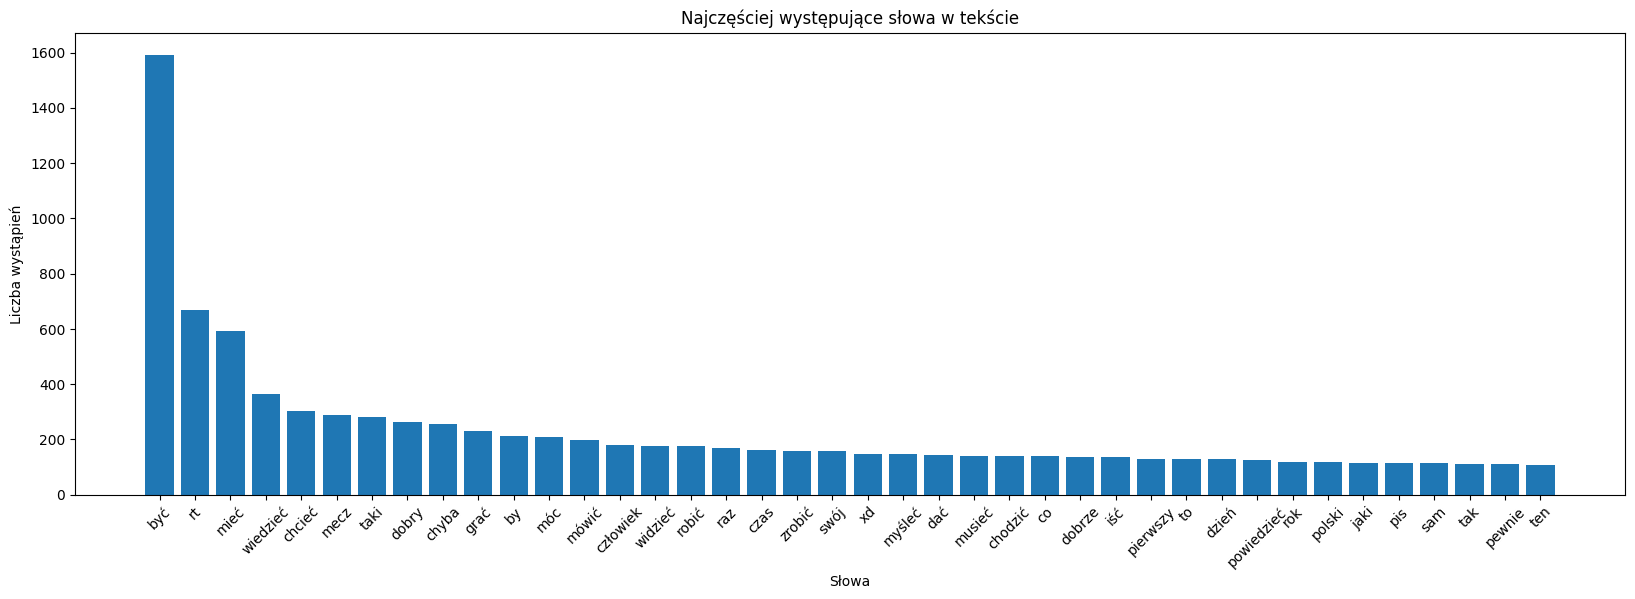

In [11]:
from collections import Counter

all_words = ' '.join(df_train_combined['text']).split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(40)
words, counts = zip(*common_words)

plt.figure(figsize=(20, 6))
plt.bar(words, counts)
plt.xlabel('Słowa')
plt.ylabel('Liczba wystąpień')
plt.title('Najczęściej występujące słowa w tekście')
plt.xticks(rotation=45)
plt.show()


# Tokenizacja


In [12]:
X_train = df_train_combined['text']
y_train = df_train_combined['isHarmful']
X_test = df_test_combined['text']
y_test = df_test_combined['isHarmful']

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model - regresja logistyczna

In [24]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)
print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       866
           1       0.60      0.02      0.04       134

    accuracy                           0.87      1000
   macro avg       0.73      0.51      0.49      1000
weighted avg       0.83      0.87      0.81      1000

[[864   2]
 [131   3]]


# Model - SVC

In [14]:
svc = SVC(kernel='linear', class_weight='balanced')
svc.fit(X_train_tfidf, y_train)

y_pred_svc = svc.predict(X_test_tfidf)
print("SVC - Classification Report:")
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))
print(f"SVC Accuracy: {svc.score(X_test_tfidf, y_test)}")

SVC - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       866
           1       0.37      0.43      0.40       134

    accuracy                           0.83      1000
   macro avg       0.64      0.66      0.65      1000
weighted avg       0.84      0.83      0.83      1000

[[769  97]
 [ 77  57]]
SVC Accuracy: 0.826


# Najbardziej istotne słowa (z regresji logistycznej)
Dane pozyskane przez analizę wag. Gdy waga dodatnia to znaczy, że słowo zwiększa pradopodobieństwo przynależenia do klasy bullying.

In [15]:
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = model.coef_[0]

sorted_indices = np.argsort(coefficients)
top_negative = sorted_indices[:10]
top_positive = sorted_indices[-10:]

print("Słowa zwiększające prawdopodobieństwo klasy 1 (cyberprzemoc):")
print(feature_names[top_positive])

print("\nSłowa zwiększające prawdopodobieństwo klasy 0 (brak cyberprzemocy):")
print(feature_names[top_negative])


Słowa zwiększające prawdopodobieństwo klasy 1 (cyberprzemoc):
['chuj' 'gnój' 'debile' 'kutas' 'dupa' 'mózg' 'debil' 'pisdzielstwo'
 'pisowski' 'pajac']

Słowa zwiększające prawdopodobieństwo klasy 0 (brak cyberprzemocy):
['mecz' 'grać' 'xd' 'klub' 'zawodnik' 'raz' 'pytanie' 'liga' 'sędzia'
 'tak']


# Wykres dla najbardziej istotnych słów

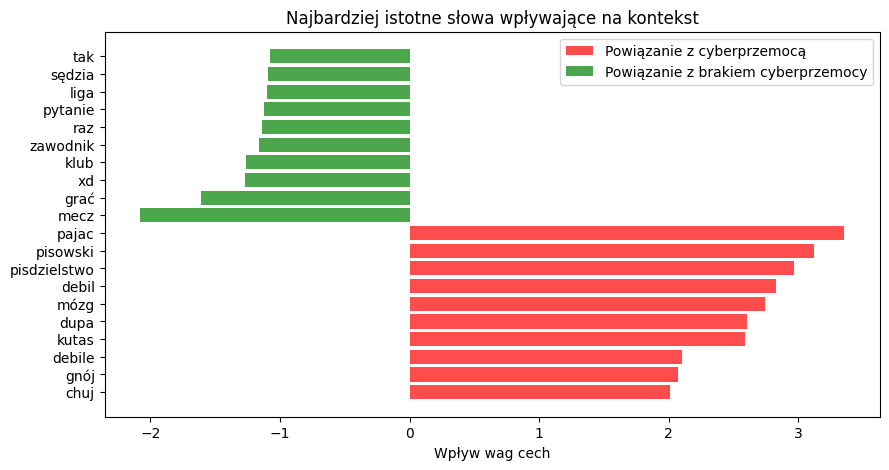

In [16]:
negative_words = feature_names[top_negative]
negative_values = coefficients[top_negative]

positive_words = feature_names[top_positive]
positive_values = coefficients[top_positive]

plt.figure(figsize=(10, 5))

plt.barh(positive_words, positive_values, color='red', alpha=0.7, label="Powiązanie z cyberprzemocą")
plt.barh(negative_words, negative_values, color='green', alpha=0.7, label="Powiązanie z brakiem cyberprzemocy")

plt.xlabel("Wpływ wag cech")
plt.title("Najbardziej istotne słowa wpływające na kontekst")
plt.legend()
plt.show()

In [22]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {rf.score(X_test_tfidf, y_test)}")

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       866
           1       0.52      0.10      0.16       134

    accuracy                           0.87      1000
   macro avg       0.70      0.54      0.55      1000
weighted avg       0.83      0.87      0.83      1000

[[854  12]
 [121  13]]
Random Forest Accuracy: 0.867
